In [68]:
import numpy as np
import scipy.sparse as sp
import pandas as pd

In [69]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

In [70]:
from sklearn.neighbors import KNeighborsRegressor

knn_clf = KNeighborsRegressor()

Define the task

Prepare data & split data

Choose the model

Train the model

Evaluate the model

Use the model

In [71]:
esol_df = pd.read_csv('data/esol.csv')
esol_df.head()

,smiles,log solubility (mol/L)
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


In [72]:
smiles = esol_df['smiles'].values
y = esol_df['log solubility (mol/L)'].values

smiles
y

array([-0.77 , -3.3  , -2.06 , ..., -3.091, -3.18 , -4.522])

In [73]:
from deepchem.feat import RDKitDescriptors

featurizer = RDKitDescriptors()
features = featurizer.featurize(smiles)
features.shape

(1128, 217)

In [74]:
print(f'Number of generated molecular descriptors: {features.shape[1]}')
features

Number of generated molecular descriptors: 217


array([[ 2.81312868,  2.47523823, -2.42509186, ...,  0.        ,
         0.        ,  0.21751779],
       [ 2.65822643,  2.10213709, -2.02528356, ...,  0.        ,
         0.        ,  0.81128275],
       [ 1.86876203,  1.86031507, -1.94442887, ...,  0.        ,
         0.        ,  0.34370646],
       ...,
       [ 2.12099818,  2.14274276, -2.15343675, ...,  0.        ,
         0.        ,  0.50606972],
       [ 1.37878349,  1.79531012, -1.90099928, ...,  0.        ,
         0.        ,  0.44444084],
       [ 2.4003692 ,  2.27135675, -2.16911981, ...,  0.        ,
         0.        ,  0.38662545]])

In [75]:
#Dropping features with NaN values
features = features[:, ~np.isnan(features).any(axis=0)]
print(f"Number of molecular descriptors without invalid values: {features.shape[1]}")
features.shape

Number of molecular descriptors without invalid values: 217


(1128, 217)

In [76]:
from deepchem.feat import MACCSKeysFingerprint
mf_featurizer = MACCSKeysFingerprint()
mf_features = mf_featurizer.featurize(smiles)
mf_features.shape

(1128, 167)

In [77]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
features = selector.fit_transform(features)
print(f"Number of molecular descriptors after removing zeo variance features: {features.shape[1]}")

Number of molecular descriptors after removing zeo variance features: 198


In [78]:
from sklearn.model_selection import train_test_split

X = features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [79]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
scalar.fit(X_train)

X_train_orignal = X_train
X_test_orignal = X_test

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [80]:
from sklearn.ensemble import RandomForestRegressor
ranf_reg = RandomForestRegressor(n_estimators=100, random_state=0)

from xgboost import XGBRegressor
xgb_reg = XGBRegressor(n_estimators=100, random_state=0)

In [81]:
from sklearn.metrics import mean_squared_error

def train_test_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    model_train_mse = mean_squared_error(y_train, y_pred_train)
    model_test_mse = mean_squared_error(y_test, y_pred_test)

    model_train_rmse = np.sqrt(model_train_mse)
    model_test_rmse = np.sqrt(model_test_mse)

    print(f"RMSE on training set: {model_train_rmse:.4f}, and test set: {model_test_rmse:.4f}")
    

In [82]:
print("Evaluating Random Forest Model")
train_test_model(ranf_reg, X_train, y_train, X_test, y_test)

print("Evaluating XGBoost Model")
train_test_model(xgb_reg, X_train, y_train, X_test, y_test)

Evaluating Random Forest Model
RMSE on training set: 0.2443, and test set: 0.6938
Evaluating XGBoost Model
RMSE on training set: 0.0281, and test set: 0.6739


XGBoost fits the training data much better.

XGBoost performs slightly better on the test set


XGBoost is heavily overfitting.
Random Forest is more stable / less overfitting.


XGBoost has the slightly better test RMSE, so it is technically better at prediction right now but XGBoost is overfitting much more

In [83]:
from sklearn.svm import SVR

svm_reg = SVR()

print("Evaluating SVM Model")
train_test_model(svm_reg, X_train, y_train, X_test, y_test)

Evaluating SVM Model
RMSE on training set: 0.5181, and test set: 0.7264


In [84]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20, 30]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=0), 
    param_grid=param_grid, 
    cv=5
)
grid_search.fit(X_train, y_train)

rf_gs = RandomForestRegressor(**grid_search.best_params_, random_state=0)

print('Best hyperparameters found:', grid_search.best_params_)
print("Evaluating Tuned Random Forest Model")
train_test_model(rf_gs, X_train, y_train, X_test, y_test)

Best hyperparameters found: {'max_depth': 30, 'n_estimators': 50}
Evaluating Tuned Random Forest Model
RMSE on training set: 0.2434, and test set: 0.6868


CLASSIFICATION

In [85]:
df_toxicity = pd.read_csv('data/toxcast_data.csv')
df_toxicity.head(5)

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
df_tox = df_toxicity.loc[:, ['smiles', "TOX21_TR_LUC_GH3_Antagonist"]].dropna()
df_tox.columns = ['smiles', 'toxic']
df_tox.sample(5)

,smiles,toxic
7702,CN1C2=CC=C(Cl)C=C2C(=NC(O)C1=O)C1=CC=CC=C1,0.0
5696,[Na+].CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S([O...,1.0
822,C1CCCNCCC1,0.0
6185,COC1=CC=C(C=O)C=C1O,0.0
3614,COC(=O)CC1=C2C=CC=CC2=CC=C1,0.0


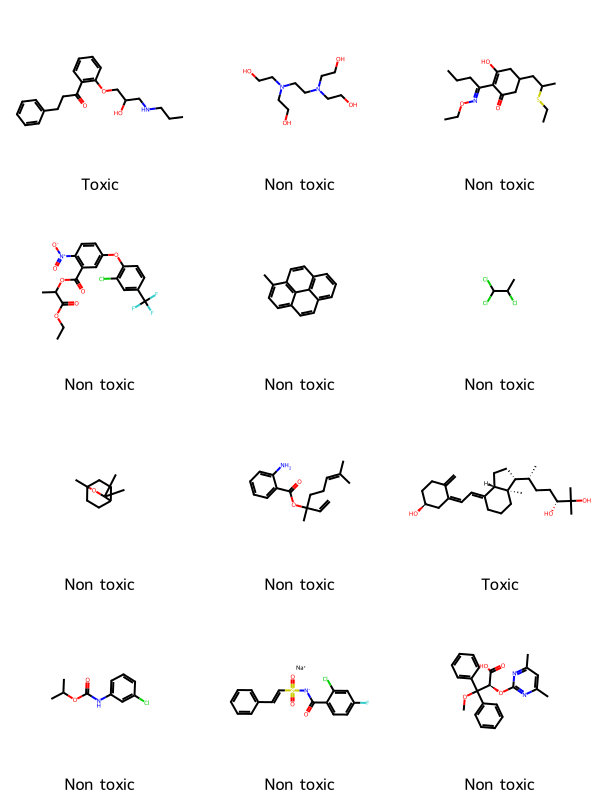

In [87]:
from rdkit import Chem
from rdkit.Chem import Draw

n = 12
df_sample = df_tox.sample(n)

smiles = df_sample['smiles'].values
legend = df_sample['toxic'].values
molecs = [Chem.MolFromSmiles(smile) for smile in smiles]

Draw.MolsToGridImage(
    molecs,
    legends=["Toxic" if i==1 else "Non toxic" for i in legend]
)

In [88]:
counts = df_tox['toxic'].value_counts()

print(f"The dataset contains {counts[1]} toxic compounds and {counts[0]} non-toxic compounds.")

The dataset contains 1764 toxic compounds and 6186 non-toxic compounds.


In [89]:

from rdkit import Chem
import numpy as np
from deepchem.feat import MordredDescriptors

featurizer = MordredDescriptors(ignore_3D=True)
features = featurizer.featurize("CCC")
print("Number of molecular descriptors:", features.shape[1])

Number of molecular descriptors: 1613


In [90]:
X_raw = df_tox.smiles.apply(lambda x: featurizer.featurize(x))
y_raw = df_tox.toxic

c:\Users\aryan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
[00:43:28] Explicit valence for atom # 0 F, 1, is greater than permitted
Failed to featurize datapoint 0, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[00:44:28] Explicit valence for atom # 2 Cl, 1, is greater than permitted
Failed to featurize datapoint 0, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChi

In [ ]:
X_raw.shape

(7950,)

In [95]:
X_raw.head()

0    [[0.0, 0.0, 0.0, 0.0, 11.936237570137333, 2.23...
1    [[0.0, 0.0, 0.0, 0.0, 14.698195805856933, 2.32...
2    [[0.0, 0.0, 0.0, 1.0, 19.577708806106966, 2.32...
3    [[0.0, 0.0, 0.0, 0.0, 11.936237570137338, 2.23...
4    [[0.0, 0.0, 0.0, 0.0, 11.936237570137333, 2.23...
Name: smiles, dtype: object

In [ ]:
# missing is a boolean Series with the exact same index as df_tox.smiles

missing = X_raw.apply(lambda x: x.shape == (1, features.shape[1]))
print(f"Number of molecules with missing features: {np.sum(~missing)}")

Number of molecules with missing features: 16


In [115]:
missing.head()

0    True
1    True
2    True
3    True
4    True
Name: smiles, dtype: bool

In [97]:
print(f"Dropping {np.sum(~missing)} molecules with missing features.")
X = X_raw[missing].values
y = y_raw[missing].values

X = np.concatenate(X)

np.save('data/features_tox.npy', X)
np.save('data/y_tox.npy', y)

Dropping 16 molecules with missing features.


In [98]:
X = np.load('data/features_tox.npy')
y = np.load('data/y_tox.npy')

In [106]:
print(X)
print(X.shape)

[[  0.           0.           0.         ...  50.           4.33333333
    2.27777778]
 [  0.           0.           0.         ...  72.           9.09722222
    3.16666667]
 [  0.           0.           0.         ...  84.           4.69444444
    3.38888889]
 ...
 [  0.           0.           1.         ...  88.          10.
    3.69444444]
 [  0.           0.           1.         ...  86.           9.6875
    3.6875    ]
 [  0.           0.           1.         ... 217.          17.59722222
   12.19444444]]
(7934, 1613)


In [110]:
valid_smiles = df_tox.smiles[missing].values

In [113]:
import pandas as pd

print(len(X), len(valid_smiles))

df_show = pd.DataFrame(X[:, :5])  # show first 5 features
df_show["SMILES"] = valid_smiles
df_show.head()

7934 7934


,0,1,2,3,4,SMILES
0,0.0,0.0,0.0,0.0,11.936238,[O-][N+](=O)C1=CC=C(Cl)C=C1
1,0.0,0.0,0.0,0.0,14.698196,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C
2,0.0,0.0,0.0,1.0,19.577709,CN1CCN(CC1)C(=O)C1CCCCC1
3,0.0,0.0,0.0,0.0,11.936238,NC1=CC=C(C=C1)[N+]([O-])=O
4,0.0,0.0,0.0,0.0,11.936238,OC1=CC=C(C=C1)[N+]([O-])=O


In [103]:
# Challenge: Which molecules couldn't be featurized? Why?
# Using code from above, visualize the faulty molecules.

X_missing = X_raw[~missing]
X_missing.sample(16)

7185    [[]]
6611    [[]]
7950    [[]]
5993    [[]]
8182    [[]]
4781    [[]]
6909    [[]]
5098    [[]]
1789    [[]]
6625    [[]]
8047    [[]]
1039    [[]]
7338    [[]]
7862    [[]]
4175    [[]]
1881    [[]]
Name: smiles, dtype: object

In [114]:

invalid_mask = ~missing
invalid_smiles = df_tox.smiles[invalid_mask].values

for s in invalid_smiles:
    print(s)

[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1
[NH4+].[NH4+].[Cl-][Pt++]([Cl-])([Cl-])[Cl-]
[Cl-][Pt]1([Cl-])[NH2+]CC[NH2+]1
FAIL
FAIL
FAIL
FAIL
FAIL
FAIL
FAIL
FAIL
FAIL
FAIL
FAIL
FAIL
FAIL


In [116]:
from rdkit import Chem
from rdkit.Chem import Draw

invalid_mols = [
    Chem.MolFromSmiles(s) 
    for s in invalid_smiles 
    if Chem.MolFromSmiles(s) is not None
]

if len(invalid_mols) > 0:
    Draw.MolsToGridImage(invalid_mols, molsPerRow=3, subImgSize=(250, 250))
else:
    print("No visualizable invalid molecules.")


No visualizable invalid molecules.


[01:34:45] Explicit valence for atom # 0 F, 1, is greater than permitted
[01:34:45] Explicit valence for atom # 2 Cl, 1, is greater than permitted
[01:34:45] Explicit valence for atom # 0 Cl, 1, is greater than permitted
[01:34:45] SMILES Parse Error: syntax error while parsing: FAIL
[01:34:45] SMILES Parse Error: check for mistakes around position 2:
[01:34:45] FAIL
[01:34:45] ~^
[01:34:45] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[01:34:45] SMILES Parse Error: syntax error while parsing: FAIL
[01:34:45] SMILES Parse Error: check for mistakes around position 2:
[01:34:45] FAIL
[01:34:45] ~^
[01:34:45] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[01:34:45] SMILES Parse Error: syntax error while parsing: FAIL
[01:34:45] SMILES Parse Error: check for mistakes around position 2:
[01:34:45] FAIL
[01:34:45] ~^
[01:34:45] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[01:34:45] SMILES Parse Error: syntax error while parsin

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=0,
)

print(f"Train set size is {X_train.shape[0]} rows, test set size is {X_test.shape[0]} rows.")


Train set size is 6347 rows, test set size is 1587 rows.


In [118]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators = 300,
    max_depth=10,
    random_state=0
)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [123]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

from xgboost import XGBClassifier
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=0
)
xgb_clf.fit(X_train, y_train)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

c:\Users\aryan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [124]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [126]:
y_pred_rf = rf_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_logreg = log_reg.predict(X_test)

In [127]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest Classifier is {acc_rf:.3f}")
auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"ROC-AUC of Random Forest Classifier is {auc_rf:.3f}")
f1s_rf = f1_score(y_test, y_pred_rf)
print(f"F1 Score of Random Forest Classifier is {f1s_rf:.3f}")
print(classification_report(y_test, y_pred_rf))

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of SVM Classifier is {acc_svm:.3f}")   
auc_svm = roc_auc_score(y_test, y_pred_svm)
print(f"ROC-AUC of SVM Classifier is {auc_svm:.3f}")
f1s_svm = f1_score(y_test, y_pred_svm)
print(f"F1 Score of SVM Classifier is {f1s_svm:.3f}")
print(classification_report(y_test, y_pred_svm))

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy of XGBoost Classifier is {acc_xgb:.3f}")
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print(f"ROC-AUC of XGBoost Classifier is {auc_xgb:.3f}")
f1s_xgb = f1_score(y_test, y_pred_xgb)
print(f"F1 Score of XGBoost Classifier is {f1s_xgb:.3f}")
print(classification_report(y_test, y_pred_xgb))

acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy of Logistic Regression Classifier is {acc_logreg:.3f}")
auc_logreg = roc_auc_score(y_test, y_pred_logreg)
print(f"ROC-AUC of Logistic Regression Classifier is {auc_logreg:.3f}")
f1s_logreg = f1_score(y_test, y_pred_logreg)
print(f"F1 Score of Logistic Regression Classifier is {f1s_logreg:.3f}")
print(classification_report(y_test, y_pred_logreg))

Accuracy of Random Forest Classifier is 0.829
ROC-AUC of Random Forest Classifier is 0.685
F1 Score of Random Forest Classifier is 0.534
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90      1206
         1.0       0.78      0.41      0.53       381

    accuracy                           0.83      1587
   macro avg       0.81      0.68      0.71      1587
weighted avg       0.82      0.83      0.81      1587

Accuracy of SVM Classifier is 0.760
ROC-AUC of SVM Classifier is 0.500
F1 Score of SVM Classifier is 0.000
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      1206
         1.0       0.00      0.00      0.00       381

    accuracy                           0.76      1587
   macro avg       0.38      0.50      0.43      1587
weighted avg       0.58      0.76      0.66      1587

Accuracy of XGBoost Classifier is 0.850
ROC-AUC of XGBoost Classifier is 0.747
F1 Score of XGBoost Cla

c:\Users\aryan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aryan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aryan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Accuracy is high because the dataset is imbalanced, most samples belong to the non-toxic class.

A classifier can achieve 75–85% accuracy simply by predicting everything as non-toxic.


However, metrics like recall, F1-score, and ROC-AUC reveal that some models (like SVM and Logistic Regression) completely fail to detect toxic molecules, even though their accuracy seems high.


Therefore, accuracy is misleading and should not be trusted for imbalanced chemical datasets.

Metrics like F1-score and ROC-AUC give a more truthful picture of model performance.

In [133]:
print("y_test:", sorted(set(y_test)))
print("y_pred_xgb:", sorted(set(y_pred_xgb)))

y_pred_xgb = y_pred_xgb.astype(float)

y_test: [0.0, 1.0]
y_pred_xgb: [0, 1]


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

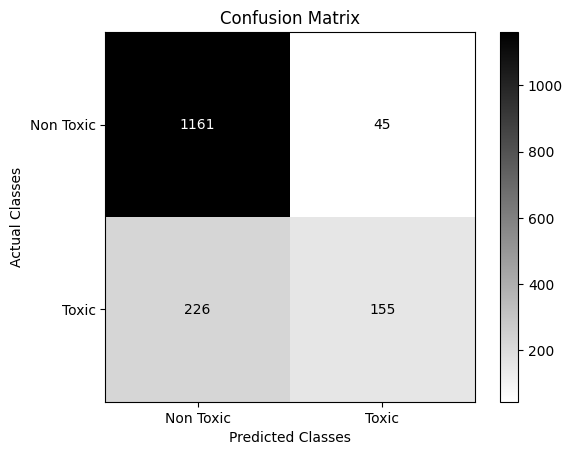

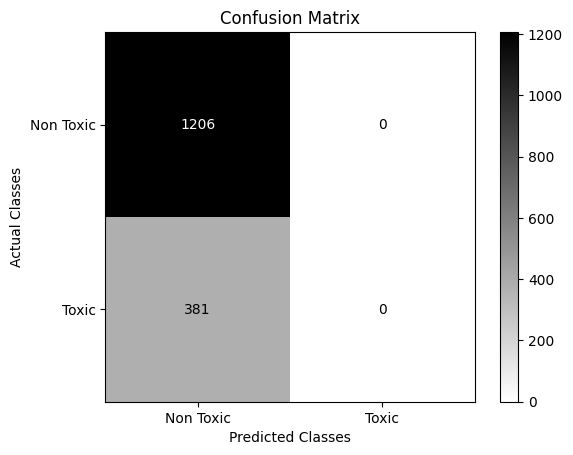

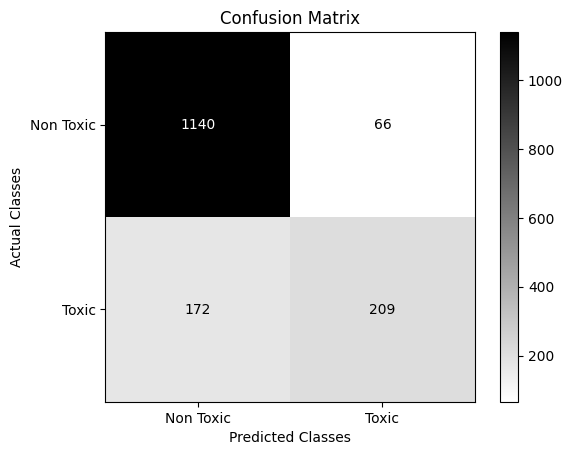

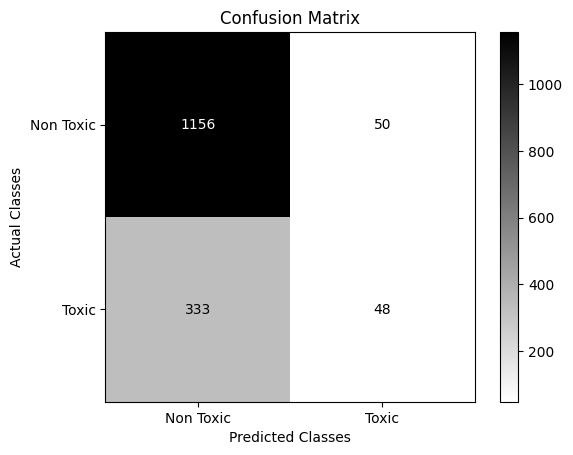

In [134]:
from pycm import ConfusionMatrix

cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred_rf)
cm.relabel(mapping={0:"Non Toxic", 1:"Toxic"})
cm.plot(number_label=True)

cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred_svm)
cm.relabel(mapping={0:"Non Toxic", 1:"Toxic"})
cm.plot(number_label=True)

cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred_xgb)
cm.relabel(mapping={0:"Non Toxic", 1:"Toxic"})
cm.plot(number_label=True)

cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred_logreg)
cm.relabel(mapping={0:"Non Toxic", 1:"Toxic"})
cm.plot(number_label=True)

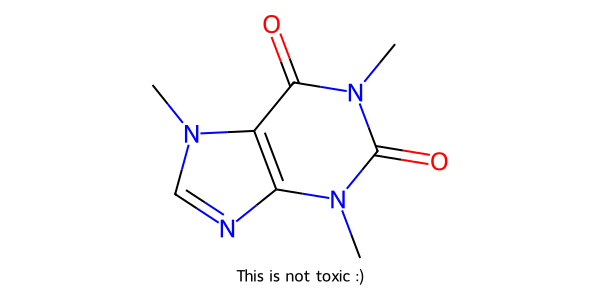

In [135]:
from IPython.display import display

def is_this_toxic(molecule, model):
    
    mol = Chem.MolFromSmiles(molecule)

    # Calculate features
    X_my_mol = featurizer.featurize(molecule)

    # Get model prediction
    is_toxic = model.predict(X_my_mol)
    is_toxic = "This molecule is toxic!" if is_toxic else "This is not toxic :)"

    img = Draw.MolsToGridImage(
        [mol],
        subImgSize=(600,300),
        legends=[is_toxic],
        molsPerRow=1
    )
    display(img)
    
    
molecule = "O=C1N(C)C(C2=C(N=CN2C)N1C)=O"
is_this_toxic(molecule, model=rf_clf)


🧪 Molecule: Caffeine
SMILES: Cn1cnc2n(C)c(=O)n(C)c(=O)c12
Expected toxicity: Non-toxic


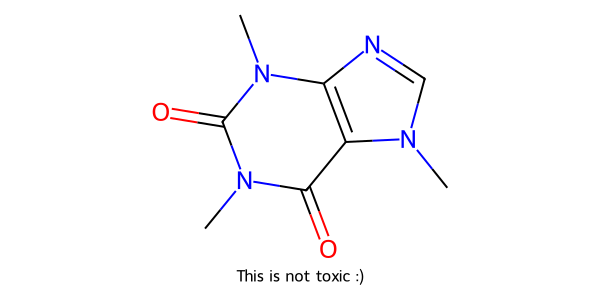


🧪 Molecule: Aspirin
SMILES: CC(=O)Oc1ccccc1C(=O)O
Expected toxicity: Non-toxic


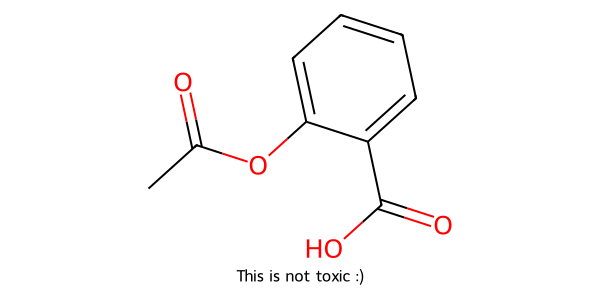


🧪 Molecule: Ibuprofen
SMILES: CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O
Expected toxicity: Non-toxic


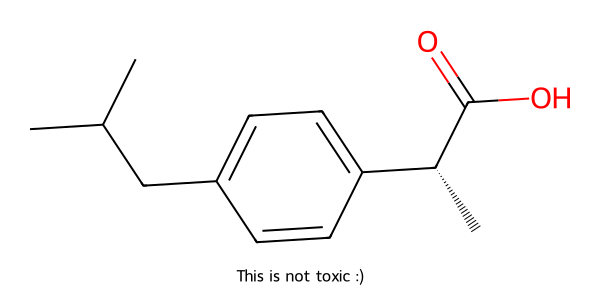


🧪 Molecule: Paracetamol
SMILES: CC(=O)Nc1ccc(O)cc1
Expected toxicity: Non-toxic


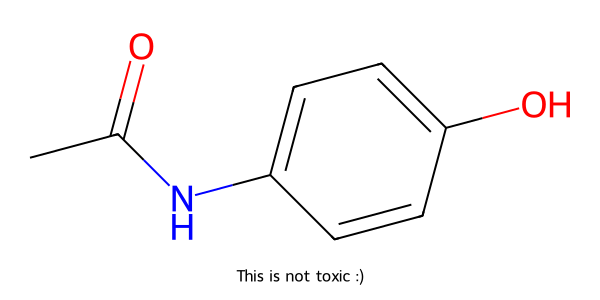


🧪 Molecule: Lactic Acid
SMILES: CC(O)C(=O)O
Expected toxicity: Non-toxic


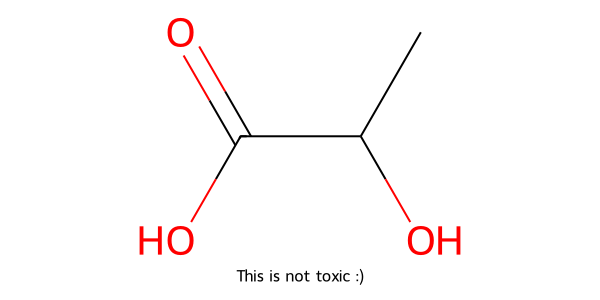


🧪 Molecule: Phenol
SMILES: c1ccc(cc1)O
Expected toxicity: Toxic


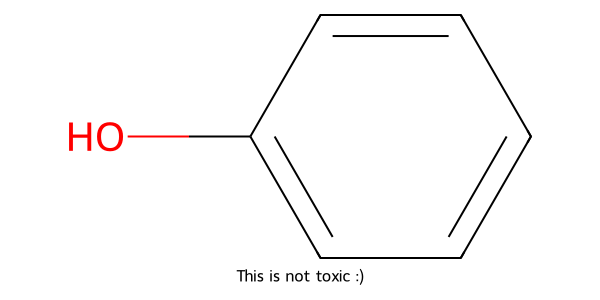


🧪 Molecule: Aniline
SMILES: c1ccc(cc1)N
Expected toxicity: Toxic


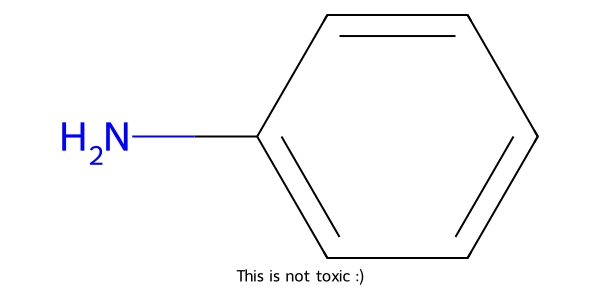


🧪 Molecule: Acetonitrile
SMILES: CC#N
Expected toxicity: Toxic


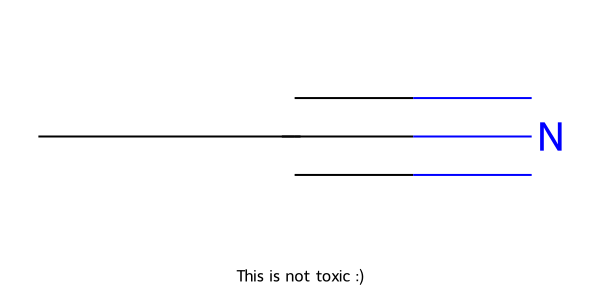


🧪 Molecule: Methanol
SMILES: CO
Expected toxicity: Toxic


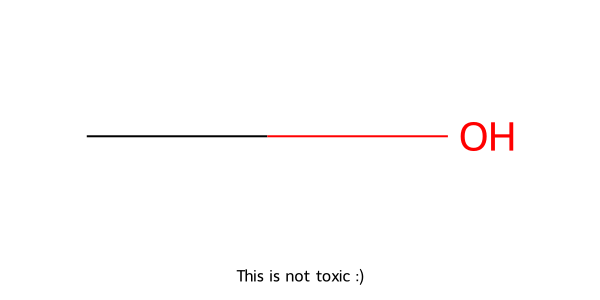


🧪 Molecule: Acrylamide
SMILES: C=CC(=O)N
Expected toxicity: Toxic


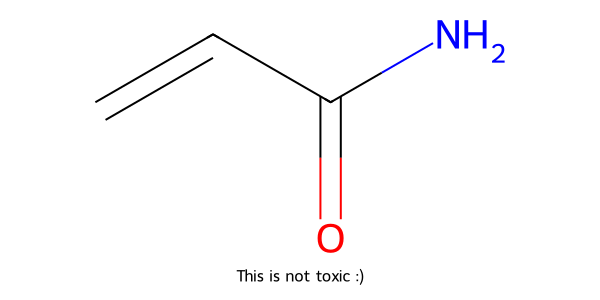


🧪 Molecule: Cyanide (HCN)
SMILES: C#N
Expected toxicity: Highly toxic


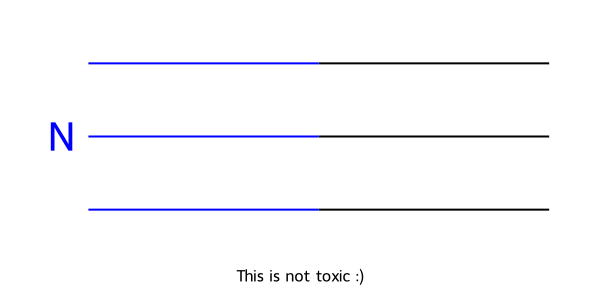


🧪 Molecule: Nitrosamine
SMILES: CN(N=O)C
Expected toxicity: Highly toxic / carcinogenic


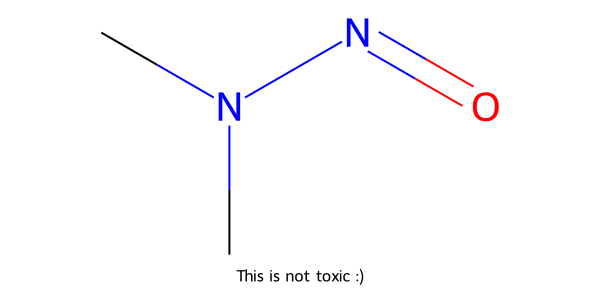


🧪 Molecule: Chloroform
SMILES: C(Cl)(Cl)Cl
Expected toxicity: Toxic


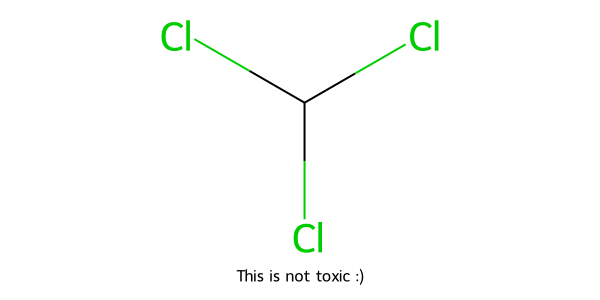


🧪 Molecule: Carbon Tetrachloride
SMILES: ClC(Cl)(Cl)Cl
Expected toxicity: Highly toxic


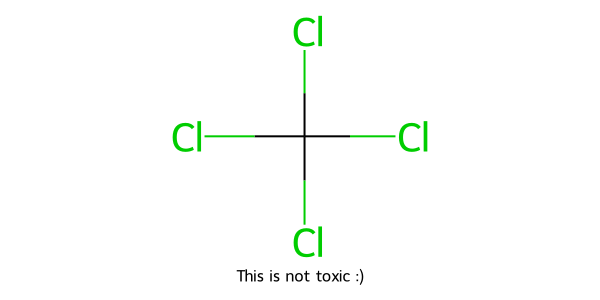


🧪 Molecule: Aflatoxin B1
SMILES: COc1cc2c3c(c1O)C(=O)OC3=CC(=O)C2
Expected toxicity: Extremely toxic


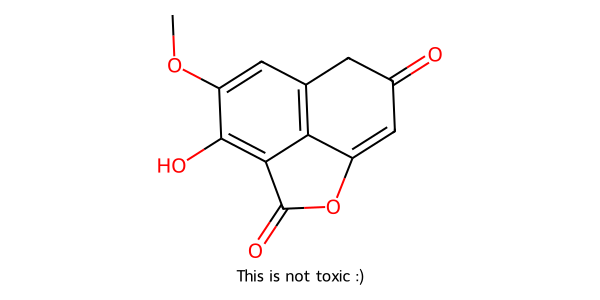

In [137]:
# List of molecules to test: (SMILES, name, expected toxicity)
test_molecules = [
    # ----- Likely NON-TOXIC -----
    ("Cn1cnc2n(C)c(=O)n(C)c(=O)c12", "Caffeine", "Non-toxic"),
    ("CC(=O)Oc1ccccc1C(=O)O", "Aspirin", "Non-toxic"),
    ("CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O", "Ibuprofen", "Non-toxic"),
    ("CC(=O)Nc1ccc(O)cc1", "Paracetamol", "Non-toxic"),
    ("CC(O)C(=O)O", "Lactic Acid", "Non-toxic"),

    # ----- Moderately TOXIC -----
    ("c1ccc(cc1)O", "Phenol", "Toxic"),
    ("c1ccc(cc1)N", "Aniline", "Toxic"),
    ("CC#N", "Acetonitrile", "Toxic"),
    ("CO", "Methanol", "Toxic"),
    ("C=CC(=O)N", "Acrylamide", "Toxic"),

    # ----- Highly TOXIC -----
    ("C#N", "Cyanide (HCN)", "Highly toxic"),
    ("CN(N=O)C", "Nitrosamine", "Highly toxic / carcinogenic"),
    ("C(Cl)(Cl)Cl", "Chloroform", "Toxic"),
    ("ClC(Cl)(Cl)Cl", "Carbon Tetrachloride", "Highly toxic"),
    
    # Aflatoxin B1 (large natural product, extremely toxic)
    ("COc1cc2c3c(c1O)C(=O)OC3=CC(=O)C2", "Aflatoxin B1", "Extremely toxic"),
]


# Function to test all molecules
from IPython.display import display

def test_all_molecules(model):
    for smi, name, expected in test_molecules:
        print(f"\n🧪 Molecule: {name}")
        print(f"SMILES: {smi}")
        print(f"Expected toxicity: {expected}")

        # Predict using your model
        is_this_toxic(smi, model=model)


# Run all tests with your Random Forest model (or XGBoost, etc.)
test_all_molecules(model=rf_clf)


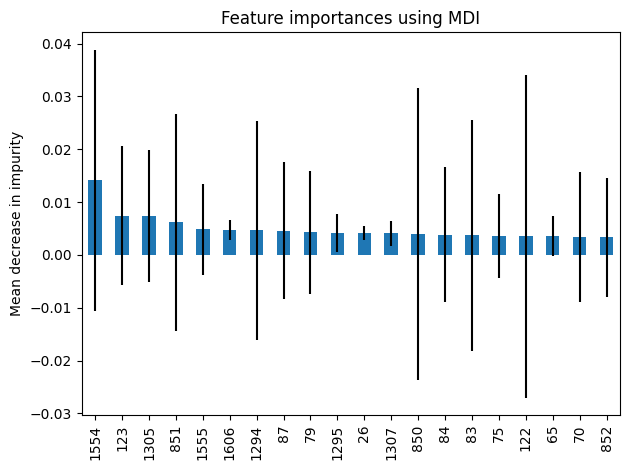

: 

In [ ]:
importances = pd.Series(rf_clf.feature_importances_, name="importance")
importances.index += 1
std = pd.Series(np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0), 
                name="std")

importances = pd.concat([importances, std], axis=1)
importances = importances.sort_values(by="importance", ascending=False).iloc[:20]


import matplotlib.pyplot as plt

fig, ax = plt.subplots()
importances["importance"].plot.bar(yerr=importances["std"], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()